# Tests Statistiques

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import *

data = pd.read_csv("../output/cleaned_data/data_transformed.csv", parse_dates=['date'])
data.head()

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class,period
0,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business,semaine-1
1,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business,semaine-1
2,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,soir,Mumbai,42220,business,semaine-1
3,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,nuit,Mumbai,44450,business,semaine-1
4,2022-02-11,Air India,apres-midi,Delhi,long,1-stop,nuit,Mumbai,46690,business,semaine-1


À cette étape de notre analyse, la mission sera de vérifier les hypothèses émises lors de l'analyse descriptive (univariée et bivariée). Que ce soit pour vérifier si la distribution d'une variable suit une loi normale, ou l'existence éffective de relation entre nos variables.

### 1. La distribution des prix de vols, suit-elle une distribution normale ?

Lors de l'analyse univariée, nous avions émis l'hypothèse selon laquelle la distibution des prix des vols éffectués en classe business suivait une loi normale.

![](../output/figures/distribution_des_prix_de_vols.png)

Nous vérifierons cela à travers un test de normalité. Ici notre échantillon étant très grand, nous utiliserons le test d'Anderson-Darling

Pour cela, on commencera par émettre nos hypothèses :
- Hypothèse nulle H0 : Ces données suivent une distribution normale
- Hypothèse alternative H1 : Ces données ne suivent pas une distribution normale

In [89]:
business_prices = data.loc[data['class'] == "business", "price"]
result = anderson(business_prices)

print(f"Statistique A²: {result.statistic}")
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"significance_level: {sl} -> critical_values: {cv}")

Statistique A²: 551.4633476008457
significance_level: 15.0 -> critical_values: 0.576
significance_level: 10.0 -> critical_values: 0.656
significance_level: 5.0 -> critical_values: 0.787
significance_level: 2.5 -> critical_values: 0.918
significance_level: 1.0 -> critical_values: 1.092


Interprétation : On constate que la statistique A² est supérieur aux valeurs critiques, quel que soit le seuil.
→ Conclusion : On rejette l'hypothèse nulle et par conséquent, cette distribution ne suit pas une loi normale.

In [90]:
Q1 = np.percentile(business_prices, 0.25); Q3 = np.percentile(business_prices, 0.75)
IQR =  Q3 - Q1
mini = Q1 - 1.5 * IQR; maxi = Q3 + 1.5 * IQR
business_prices = business_prices[(business_prices > mini) & (business_prices < maxi)]

In [91]:
result = anderson(business_prices)

print(f"Statistique A²: {result.statistic}")
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"significance_level: {sl} -> critical_values: {cv}")

Statistique A²: 139.7205257289088
significance_level: 15.0 -> critical_values: 0.575
significance_level: 10.0 -> critical_values: 0.655
significance_level: 5.0 -> critical_values: 0.786
significance_level: 2.5 -> critical_values: 0.917
significance_level: 1.0 -> critical_values: 1.091


Même après suppression des Outliers, le résultat est le même. Cette distribution ne suit pas une loi normale.

À présent, on effectue le même processus pour les prix des vols de la classe économique

In [92]:
economic_prices = data.loc[data['class'] == "economy", 'price'].dropna()

result = anderson(economic_prices)
print(f"Statistique A²: {result.statistic}")
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"significance_level: {sl} -> critical_values: {cv}")

Statistique A²: 7684.822529700468
significance_level: 15.0 -> critical_values: 0.576
significance_level: 10.0 -> critical_values: 0.656
significance_level: 5.0 -> critical_values: 0.787
significance_level: 2.5 -> critical_values: 0.918
significance_level: 1.0 -> critical_values: 1.092


Interprétation : La statistique A² est également supérieur à toutes les valeurs critiques.
→ Conclusion : On rejette l'hypothèse nulle, et par conséquent cette distribution ne suit pas une loi normale.

### 2. Y a-t-il une période où une compagnie aérienne compte plus de vols que d'autres ?

Pour cette question, nous avions retenu que les voyageurs montraient une préférence marquée et
constante pour la compagnie aérienne Vistara, mais que cela était indépendamment de la période. Donc à présent vérifions cette hypothèse.

Nous sommes face à deux variables catégorielles, les deux constituées de 8 groupes. On utilisera donc le test du chi².

On commence par émettre nos hypothèses :
- Hypothèse nulle H0 : La compagnie aérienne choisie pour un vol ne dépend pas de la période.
- Hypothèse alternative H1 : La compagnie aérienne choisie pour un vol dépend de la période.

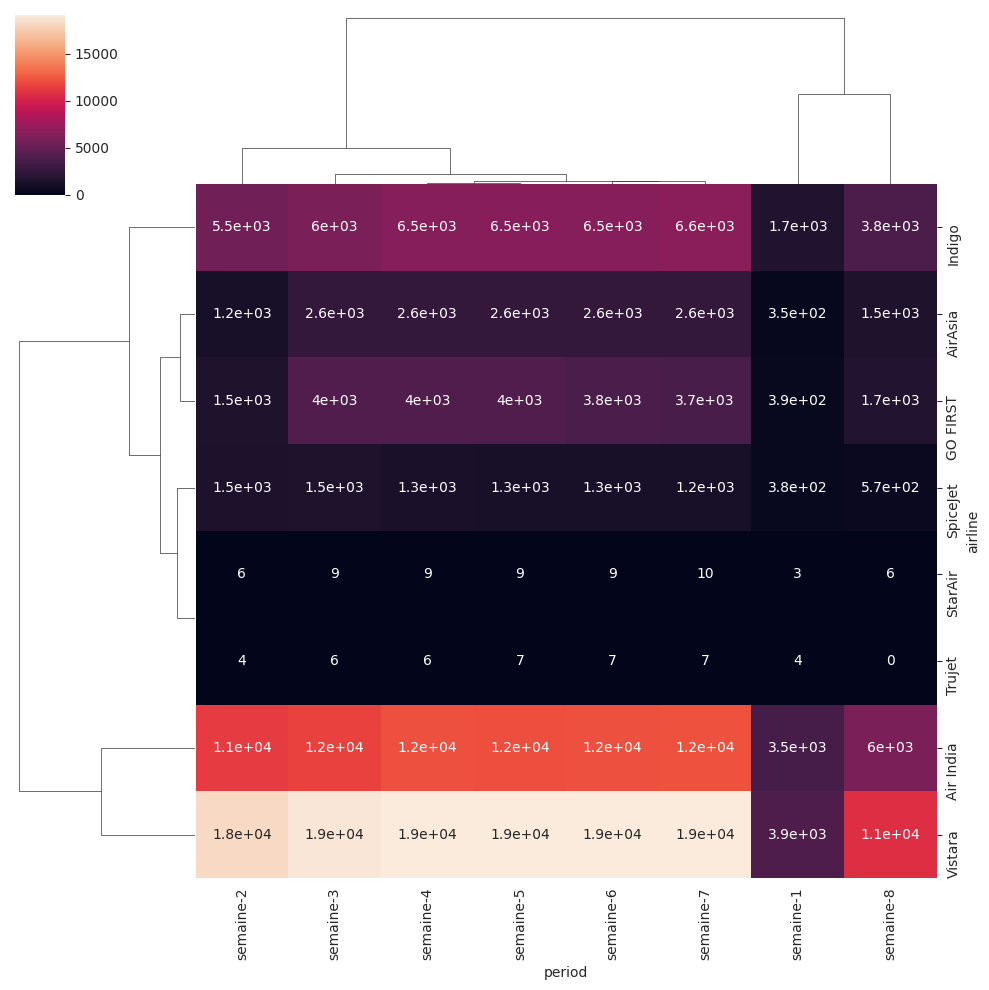

In [93]:
# Visualisation
period = data["period"]
airline = data["airline"]
table_contingency = pd.crosstab(airline, period)

sns.clustermap(table_contingency, annot=True)
plt.show()

In [94]:
def cramers_v(table):
    # Tableau croisé
    chi_2, _, _, _ = chi2_contingency(table)
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi_2 / (n * (min(r, k) - 1)))

print(f"")

chi2_stat, p_value, dof, expected = chi2_contingency(table_contingency)
print(f"chi²: {chi2_stat}\np_value: {p_value}\ndegré de liberté: {dof}\nV de Cramer: {cramers_v(table_contingency)}\nFréquence attendues: {expected}")


chi²: 2601.0629395267842
p_value: 0.0
degré de liberté: 49
V de Cramer: 0.03518309874323331
Fréquence attendues: [[2.75054681e+03 1.05570121e+04 1.20162274e+04 1.22789670e+04
  1.22689964e+04 1.22091726e+04 1.22264191e+04 6.58465871e+03]
 [5.46049440e+02 2.09581982e+03 2.38550902e+03 2.43766913e+03
  2.43568972e+03 2.42381326e+03 2.42723711e+03 1.30721251e+03]
 [7.86992608e+02 3.02059591e+03 3.43810986e+03 3.51328551e+03
  3.51043269e+03 3.49331577e+03 3.49825038e+03 1.88401728e+03]
 [1.46599262e+03 5.62670002e+03 6.40443589e+03 6.54447143e+03
  6.53915726e+03 6.50727225e+03 6.51646432e+03 3.50950620e+03]
 [3.06398375e+02 1.17600301e+03 1.33855295e+03 1.36782094e+03
  1.36671026e+03 1.36004616e+03 1.36196734e+03 7.33500959e+02]
 [2.07416501e+00 7.96095702e+00 9.06133945e+00 9.25946926e+00
  9.25195048e+00 9.20683785e+00 9.21984330e+00 4.96543763e+00]
 [1.39411091e+00 5.35080718e+00 6.09040849e+00 6.22357770e+00
  6.21852410e+00 6.18820249e+00 6.19694385e+00 3.33742530e+00]
 [4.3475518

La p valeur étant inférieur à 0.05, on rejette l'hypothèse nulle H0. Par conséquent, il existe un lien entre la période et la compagnie aérienne empruntée pour les vols. Cependant, le V de Cramer étant très faible (inférieur à 0.1), ce lien est donc négligeable.
→ L'hypothèse selon laquelle les voyageurs montrent une préférence pour une compagnie aérienne indépendamment de la période est ainsi vérifiée.

### 3. Quel moment de la journéee est priviligié dans une période X donnée pour le départ d'un vol ?

Ici, nous avions retenu que les voyageurs montraient une préférence forte et
constante pour les vols du matin, mais que cela était également indépendamment de la période. Donc à présent vérifions cette hypothèse.

Nous sommes face à deux variables catégorielles, l'une constituée de huit groupes et l'autre de six. On utilisera donc aussi le test du chi².

On commence par émettre nos hypothèses :
- Hypothèse nulle H0 : Le moment de la journée choisie pour le départ d'un vol ne dépend pas de la période.
- Hypothèse alternative H1 : Le moment de la journée choisie pour le départ d'un vol dépend de la période.

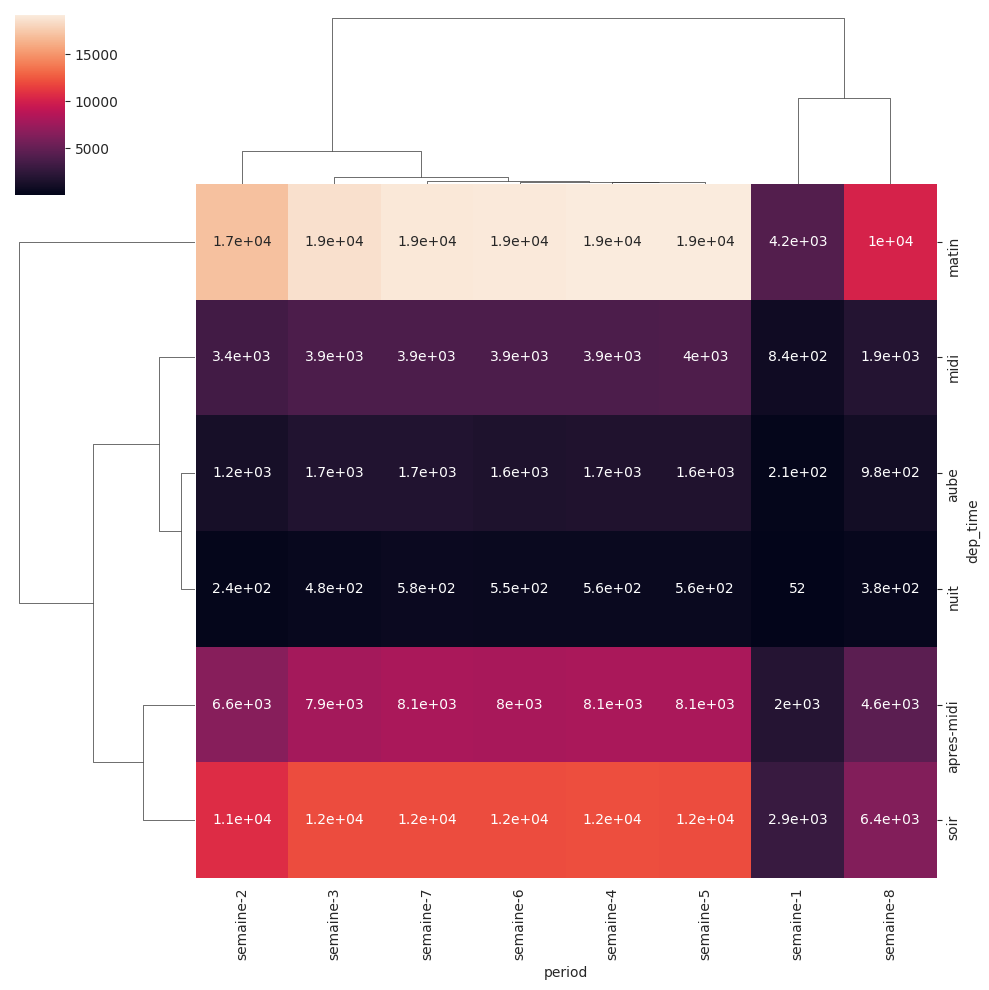

In [95]:
# On construit le tableau de contingence
dep_time = data.dep_time
table_contingency = pd.crosstab(dep_time, period)
# Puis, on visualise nos deux varibles à travers un clustermap
sns.clustermap(table_contingency, annot=True)
plt.show()

In [96]:
# Enfin, on effectue le test du chi²
chi2_stat, p_value, dof, expected = chi2_contingency(table_contingency)
print(f"chi²: {chi2_stat}\np_value: {p_value}\ndegré de liberté: {dof}\nV de Cramer: {cramers_v(table_contingency)}\nFréquences attendues: {expected}")

chi²: 420.85372188111995
p_value: 1.1131879419191213e-67
degré de liberté: 35
V de Cramer: 0.016745119861330246
Fréquences attendues: [[ 1816.25448894  6971.05769167  7934.61388424  8108.10738152
   8101.52352573  8062.02039096  8073.40868207  4348.01395487]
 [  363.3529059   1394.60306081  1587.36841649  1622.07686004
   1620.7597191   1612.8568735   1615.13517133   869.84699282]
 [ 4303.72237509 16518.33327781 18801.53663444 19212.6397319
  19197.0388964  19103.43388344 19130.41911241 10302.87608851]
 [  875.26363006  3359.3933547   3823.73670307  3907.34423117
   3904.17143266  3885.13464165  3890.62272555  2095.33328114]
 [  116.05123225   445.42207061   506.98936978   518.07489456
    517.65421311   515.13012439   515.85778961   277.82030568]
 [ 2732.35536774 10487.1905444  11936.75499197 12197.75690081
  12187.85221299 12128.42408605 12145.55651905  6541.10937698]]


La p valeur étant aussi inférieur à 0.05, on rejette l'hypothèse nulle H0. Par conséquent, il existe un lien entre la période et le moment de la journée choisie pour les vols. Cependant, le V de Cramer étant très faible (inférieur à 0.1), ce lien est donc négligeable.
→ L'hypothèse selon laquelle les voyageurs montrent une préférence pour les départs de vols en matinée indépendamment de la période est ainsi vérifiée.

### 4. Quel sont les destinations les plus fréquentées dans une période X donnée ?

Le processus reste le même, à cette question, nous avions répondu que les voyageurs montraient également une préférence forte et constante pour les vols à destination de Mumbai, mais que cela était indépendamment de la période. Pour vérifier cela, on passera par le test du chi² aussi parce qu'il s'agit de deux variables catégorielles, l'une constituée de huit groupes et l'autre de six.

On commence par émettre nos hypothèses :
- Hypothèse nulle H0 : La destination des vols n'est pas influencée par la période pendant laquelle elle a été prise.
- Hypothèse alternative H1 : La destination des vols est influencée par la période pendant laquelle elle a été prise.

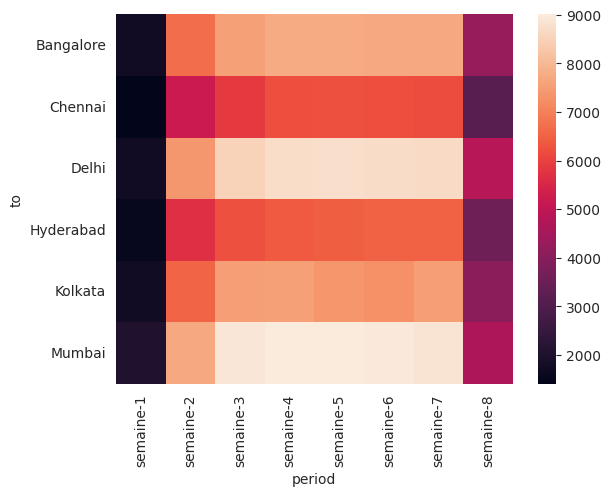

In [97]:
# Table de contingence
table_contingency = pd.crosstab(data.to, data.period)
# Heatmap
sns.heatmap(table_contingency)
plt.show()

In [98]:
# Test de chi²
chi2_stat, p_value, dof, expected = chi2_contingency(table_contingency)
v_cramer = cramers_v(table_contingency)
print(f"chi²: {chi2_stat}\np valeur: {p_value}\ndegré de liberté: {dof}\nV de Cramer: {v_cramer}\nfréquences attendues: {expected}")

chi²: 88.50739434532073
p valeur: 1.5873663086875023e-06
degré de liberté: 35
V de Cramer: 0.007679137643178549
fréquences attendues: [[1737.81024845 6669.97690734 7591.91699702 7757.91729018 7751.61779187
  7713.82080205 7724.71723155 4160.22273154]
 [1372.28116942 5267.02136704 5995.04160143 6126.12557715 6121.15110833
  6091.30429539 6099.90878201 3285.16609923]
 [1949.88511969 7483.9521357  8518.40181956 8704.66007289 8697.59181097
  8655.18223944 8667.40842222 4667.91837952]
 [1454.29569395 5581.80543803 6353.33587624 6492.25409918 6486.98233072
  6455.35171996 6464.47045459 3481.50438734]
 [1683.94996369 6463.25303982 7356.61926431 7517.47467869 7511.37042194
  7474.74488144 7485.30359582 4031.28415428]
 [2008.7778048  7709.99111206 8775.68444144 8967.56828191 8960.28653617
  8916.59606172 8929.19151381 4808.90424809]]


On obtient le même resultat que pour les tests précédents. La p valeur nous permet de rejetter l'hypothèse nulle, cependant le V de Cramer nous indique un lien négligeable entre nos deux variables. Ainsi notre hypothèse de départ est bien vérifiée.

### 5. Le prix d'un vol est-il influencé par la période pendant laquelle le vol sera effectué ?

Pour cette question, nous avions remarqué que la période semblait influencer les prix des vols. Nous allons donc vérifier cela avec le test Kruskal-Wallis parce qu'il s'agit d'une variable qualitative de plus de trois groupes et d'une variable quantitative dont la distribution ne suit pas une loi normale.

On émet nos hypothèses :
- Hypoyhèse nulle H0 : Le prix des vols est le même quelle que soit la période
- Hypothèse alternative H1 : Le prix des vols dépend de la période

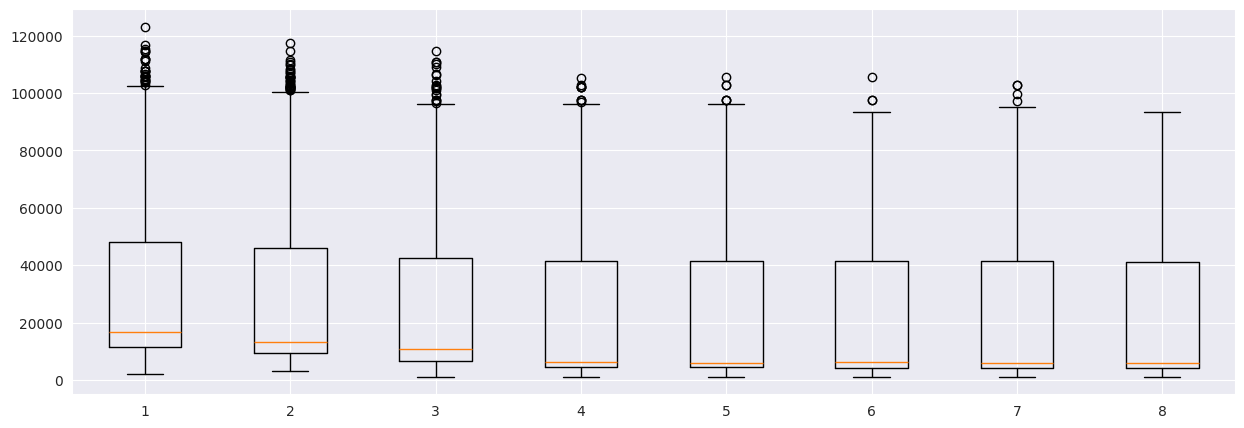

In [99]:
# Isolation des groupes
semaine_1 = data.loc[data.period == "semaine-1", "price"]
semaine_2 = data.loc[data.period == "semaine-2", "price"]
semaine_3 = data.loc[data.period == "semaine-3", "price"]
semaine_4 = data.loc[data.period == "semaine-4", "price"]
semaine_5 = data.loc[data.period == "semaine-5", "price"]
semaine_6 = data.loc[data.period == "semaine-6", "price"]
semaine_7 = data.loc[data.period == "semaine-7", "price"]
semaine_8 = data.loc[data.period == "semaine-8", "price"]

semaines = [semaine_1, semaine_2, semaine_3, semaine_4, semaine_5, semaine_6, semaine_7, semaine_8]
# Visualisation
plt.figure(figsize=(15, 5))
plt.boxplot(semaines)
plt.show()

In [100]:
# test de kruskal-wallis
stat_kruskal, p_value = kruskal(semaine_1, semaine_2, semaine_3, semaine_4, semaine_5, semaine_6, semaine_7, semaine_8)
print(f"Kruskal stat: {stat_kruskal}\n p valeur: {p_value}")

Kruskal stat: 27570.595836385633
 p valeur: 0.0


La p valeur est inférieur au seuil de 0.05. Ainsi, on peut rejetter l'hypothèse nulle et confirmer l'existence d'une différence significative entre au moins deux groupes.

→ Conclusion : La période a une influence statistiquement significative sur le prix des vols. Cela signifie que le prix varie selon les semaines considérées. Cependant, visuellement avec les boxplots obtenues plus haut, on ne remarque pas de différences notables des prix d'une semaine à l'autre. Donc passons par le test Dunn post hoc pour confirmer l'existence ou non de la relation.

In [101]:
import scikit_posthocs as sp
sp.posthoc_dunn(data, val_col='price', group_col='period', p_adjust='bonferroni')

,semaine-1,semaine-2,semaine-3,semaine-4,semaine-5,semaine-6,semaine-7,semaine-8
semaine-1,1.000000e+00,6.886269e-29,4.268910e-295,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
semaine-2,6.886269e-29,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
semaine-3,4.268910e-295,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
semaine-4,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.460170e-08,3.967270e-12,2.619820e-52,5.560227e-57
semaine-5,0.000000e+00,0.000000e+00,0.000000e+00,1.460170e-08,1.000000e+00,1.000000e+00,7.781736e-19,2.531356e-26
semaine-6,0.000000e+00,0.000000e+00,0.000000e+00,3.967270e-12,1.000000e+00,1.000000e+00,2.789391e-14,9.719415e-22
semaine-7,0.000000e+00,0.000000e+00,0.000000e+00,2.619820e-52,7.781736e-19,2.789391e-14,1.000000e+00,3.825439e-02
semaine-8,0.000000e+00,0.000000e+00,0.000000e+00,5.560227e-57,2.531356e-26,9.719415e-22,3.825439e-02,1.000000e+00


Le suspens est rompu, Oui ! il y a bien une relation entre la période et le prix des vols. En effet, le tableau obtenu de ce test nous montre les p valeurs des associations des différents groupes et presque tous sont inférieurs au seuil de 0.05. D'où la conclusion.